In [116]:
import pandas as pd

# Load data
campus_info = pd.read_csv('../../Data/SMTO_2015/Campus_Info.csv')
df = pd.read_csv('../../Data/SMTO_2015/SMTO_2015_Households.csv')[['HmTTS2006', 'hhlivingsituation', 'hhcarnumber','hhnumyoungerthan18','hhnumolderorequalto18','hhincomelevel']]
df = df.join(pd.read_csv('../../Data/SMTO_2015/SMTO_2015_Respondents.csv')[['pscampusattend', 'personstatusgrad', 'personstatustime', 'pscmpgender','psdrivinglicenseownerflag','psworknumhoursperweek']])
df.head()

,HmTTS2006,hhlivingsituation,hhcarnumber,hhnumyoungerthan18,hhnumolderorequalto18,hhincomelevel,pscampusattend,personstatusgrad,personstatustime,pscmpgender,psdrivinglicenseownerflag,psworknumhoursperweek
0,261.0,Live with family/parents,1,3,4,Unknown,Scarborough (UTSC),UG,FT,Female,0,NaN
1,71.0,Live with partner,0,0,2,"$ 90,000 - 119,999",Downtown Toronto (St. George),Grad,FT,Female,1,NaN
2,3714.0,Live with family/parents,1,0,4,Unknown,Downtown Toronto (St. George),UG,FT,Female,1,NaN
3,74.0,Live with roommates,0,0,4,Unknown,Downtown Toronto (St. George),UG,FT,Male,1,NaN
4,71.0,Live with partner,0,0,2,"$ 30,000 - 59,999",Downtown Toronto (St. George),Grad,FT,Male,1,NaN


In [117]:
df = df.rename(columns={'HmTTS2006': 'HomeZone', 'pscampusattend': 'Campus', 'hhlivingsituation': 'Family', 
                       'personstatusgrad': 'Level', 'personstatustime': 'Status', 'psuniversityinvolvednumyears': 'Years', 'hhcarnumber': 'Cars',
                       'hhincomelevel': 'Income', 'pscmpgender': 'Gender', 'psdrivinglicenseownerflag': 'Licence', 'psworknumhoursperweek': 'Work',
                       'hhnumyoungerthan18': 'Children', 'hhnumolderorequalto18':'Adults'})
df.columns

Index(['HomeZone', 'Family', 'Cars', 'Children', 'Adults', 'Income', 'Campus',
       'Level', 'Status', 'Gender', 'Licence', 'Work'],
      dtype='object')

In [118]:
# Clean and reformat
df = df[df['HomeZone'].notnull()]
df = df[df['Campus'].notnull()]
df['HomeZone'] = pd.to_numeric(df['HomeZone'], downcast='signed')
df['Family'] = (df['Family'] == 'Live with family/parents')*1
df.columns

Index(['HomeZone', 'Family', 'Cars', 'Children', 'Adults', 'Income', 'Campus',
       'Level', 'Status', 'Gender', 'Licence', 'Work'],
      dtype='object')

In [119]:
df.head()

,HomeZone,Family,Cars,Children,Adults,Income,Campus,Level,Status,Gender,Licence,Work
0,261,1,1,3,4,Unknown,Scarborough (UTSC),UG,FT,Female,0,NaN
1,71,0,0,0,2,"$ 90,000 - 119,999",Downtown Toronto (St. George),Grad,FT,Female,1,NaN
2,3714,1,1,0,4,Unknown,Downtown Toronto (St. George),UG,FT,Female,1,NaN
3,74,0,0,0,4,Unknown,Downtown Toronto (St. George),UG,FT,Male,1,NaN
4,71,0,0,0,2,"$ 30,000 - 59,999",Downtown Toronto (St. George),Grad,FT,Male,1,NaN


In [120]:
def row_to_segment(x):
    if x.Level == 'Other':
        return 0
    elif x.Level == 'UG':
        return 3 if x.Status == 'PT' else (not x.Family) + 1
    else:
        return 6 if x.Status == 'PT' else (4 + (not x.Family))

df['Segment'] = df.apply(row_to_segment, axis=1)
#df['Segment'] = df['Segment'].astype(str)

In [121]:
# Dataframe with walk distances
df_path = pd.read_csv('../../../LoS/Walk_Distances.csv')
origins = list(set(list(df_path['Origin'])))
dists = list(df_path['Data'])

# Function for distance lookup
def find_distance(origin, destination):
    try:
        i = origins.index(origin)
    except ValueError:
        return -1
    j = origins.index(destination)
    return dists[i*2392 + j] / 1000

# List of campus' TTS zones from Joven's MOE data
campus_zones = list(campus_info['Zone'])
school_codes = list(campus_info['Code'])

# Load distances into dataframe
for i in range(len(campus_zones)):
    df["Dist." + school_codes[i]] = df['HomeZone'].apply(lambda x: find_distance(x, campus_zones[i]))
df = df[df['Dist.SG'] != -1]
df.columns

Index(['HomeZone', 'Family', 'Cars', 'Children', 'Adults', 'Income', 'Campus',
       'Level', 'Status', 'Gender', 'Licence', 'Work', 'Segment', 'Dist.SG',
       'Dist.SC', 'Dist.MI', 'Dist.YK', 'Dist.YG', 'Dist.RY', 'Dist.OC'],
      dtype='object')

In [122]:
df.head()

,HomeZone,Family,Cars,Children,Adults,Income,Campus,Level,Status,Gender,Licence,Work,Segment,Dist.SG,Dist.SC,Dist.MI,Dist.YK,Dist.YG,Dist.RY,Dist.OC
0,261,1,1,3,4,Unknown,Scarborough (UTSC),UG,FT,Female,0,NaN,1,10.256060,14.88098,29.20657,22.59214,9.218413,9.580635,11.241730
1,71,0,0,0,2,"$ 90,000 - 119,999",Downtown Toronto (St. George),Grad,FT,Female,1,NaN,5,1.132351,23.03920,19.64290,15.87906,11.211150,2.675173,2.723838
2,3714,1,1,0,4,Unknown,Downtown Toronto (St. George),UG,FT,Female,1,NaN,1,23.319230,45.63271,4.51742,28.58045,32.555200,24.964000,23.686150
3,74,0,0,0,4,Unknown,Downtown Toronto (St. George),UG,FT,Male,1,NaN,2,0.699414,24.11954,19.43932,16.81186,12.830410,2.314008,1.541276
4,71,0,0,0,2,"$ 30,000 - 59,999",Downtown Toronto (St. George),Grad,FT,Male,1,NaN,5,1.132351,23.03920,19.64290,15.87906,11.211150,2.675173,2.723838


In [123]:
y = df[['Campus','Segment']]
#x = df.drop(columns = ['HomeZone', 'Campus', 'Work'])
x = df[['Dist.SG', 'Dist.SC', 'Dist.MI', 'Dist.YK', 'Dist.YG', 'Dist.RY', 'Dist.OC','Segment']]
x = pd.get_dummies(x)
x.head()

,Dist.SG,Dist.SC,Dist.MI,Dist.YK,Dist.YG,Dist.RY,Dist.OC,Segment
0,10.256060,14.88098,29.20657,22.59214,9.218413,9.580635,11.241730,1
1,1.132351,23.03920,19.64290,15.87906,11.211150,2.675173,2.723838,5
2,23.319230,45.63271,4.51742,28.58045,32.555200,24.964000,23.686150,1
3,0.699414,24.11954,19.43932,16.81186,12.830410,2.314008,1.541276,2
4,1.132351,23.03920,19.64290,15.87906,11.211150,2.675173,2.723838,5


--------------------------- Segment: 0 -------------------------------------
Accuracy: 0.4333333333333333
Av. Prob: 0.3916246377465128
--------------------------- Segment: 1 -------------------------------------
Accuracy: 0.2939922480620155
Av. Prob: 0.26249198039461025
--------------------------- Segment: 2 -------------------------------------
Accuracy: 0.6604166666666667
Av. Prob: 0.5833556700509126
--------------------------- Segment: 3 -------------------------------------
Accuracy: 0.3504761904761905
Av. Prob: 0.3192372793344222
--------------------------- Segment: 4 -------------------------------------
Accuracy: 0.5291828793774319
Av. Prob: 0.4600246300257057
--------------------------- Segment: 5 -------------------------------------
Accuracy: 0.7180616740088106
Av. Prob: 0.6060198546132183


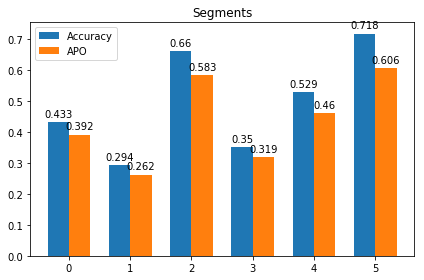

In [124]:
def mean(lst): 
    return sum(lst) / len(lst) 

accs_mean = []
probs_mean = []

for i in range(6):
    
    accs = []
    prob = []
    
    print("--------------------------- Segment: " + str(i) + " -------------------------------------")
    x_temp = x[x['Segment'] == i]
    x_temp = x_temp[['Dist.SG', 'Dist.SC', 'Dist.MI', 'Dist.YK', 'Dist.YG', 'Dist.RY', 'Dist.OC']]
    y_temp = y[y['Segment'] == i]
    y_temp = y_temp['Campus']
    
    for j in range(5):    
    
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(x_temp, y_temp, test_size=0.3)

        from sklearn.ensemble import RandomForestClassifier
        rf = RandomForestClassifier(n_estimators=100)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        accs.append(rf.score(X_test, y_test))

        probs = rf.predict_proba(X_test)
        schools = list(rf.classes_)
        results = pd.concat((y_test.reset_index(drop=True), pd.DataFrame(probs)), axis=1)
        prob.append(results.apply(lambda x: x[schools.index(x.Campus)], axis=1).mean())
        #print(probs)
        #print(probs[1])
    
    accs_mean.append(mean(accs))
    probs_mean.append(mean(prob))
    
    print('Accuracy:', accs_mean[i])
    print('Av. Prob:', probs_mean[i])
    
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['0','1','2','3','4','5']

x_array = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x_array - width/2, accs_mean, width, label='Accuracy')
rects2 = ax.bar(x_array + width/2, probs_mean, width, label='APO')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Percentage')
ax.set_title('Segments')
ax.set_xticks(x_array)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(), 3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

1 Full-Sample Model:

In [89]:
y = df['Campus']
#x = df.drop(columns = ['HomeZone', 'Campus', 'Work'])
x = df[['Dist.SG', 'Dist.SC', 'Dist.MI', 'Dist.YK', 'Dist.YG', 'Dist.RY', 'Dist.OC','Segment']]
x = pd.get_dummies(x)
x.head()

,Dist.SG,Dist.SC,Dist.MI,Dist.YK,Dist.YG,Dist.RY,Dist.OC,Segment
0,10.256060,14.88098,29.20657,22.59214,9.218413,9.580635,11.241730,1
1,1.132351,23.03920,19.64290,15.87906,11.211150,2.675173,2.723838,5
2,23.319230,45.63271,4.51742,28.58045,32.555200,24.964000,23.686150,1
3,0.699414,24.11954,19.43932,16.81186,12.830410,2.314008,1.541276,2
4,1.132351,23.03920,19.64290,15.87906,11.211150,2.675173,2.723838,5


In [90]:
print(y.isnull().sum(), x.isnull().sum().sum())

0 0


In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [105]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

['Downtown Toronto (St. George)' 'Downtown Toronto (St. George)'
 'Downtown Toronto (St. George)' ... 'Downtown Toronto (St. George)'
 'Downtown Toronto (St. George)' 'Downtown Toronto (St. George)']


In [102]:
print("Accuracy:", rf.score(X_test, y_test))

Accuracy: 0.46863799283154123


In [94]:
pd.Series(rf.feature_importances_, index = x.columns).sort_values(ascending=False)

Segment    0.217293
Dist.SG    0.120920
Dist.OC    0.119560
Dist.SC    0.113033
Dist.YK    0.112760
Dist.RY    0.111859
Dist.MI    0.107964
Dist.YG    0.096612
dtype: float64

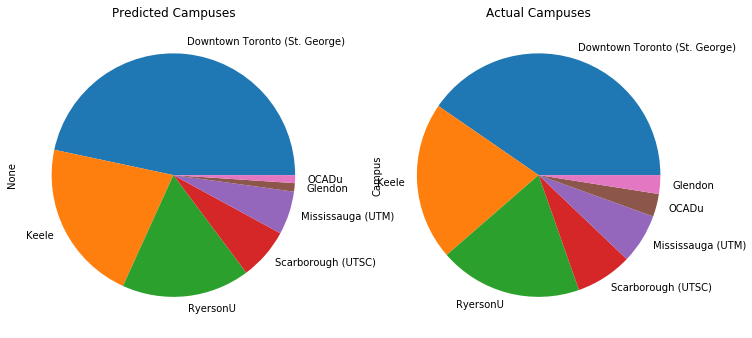

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 12))
plt.tight_layout()
plt.subplot(1, 2, 1)
pd.Series(y_pred).value_counts().plot.pie()
plt.title("Predicted Campuses")
plt.subplot(1, 2, 2)
pd.Series(y_test).value_counts().plot.pie()
plt.title("Actual Campuses")
plt.show()

In [106]:
probs = rf.predict_proba(X_test)
schools = list(rf.classes_)
results = pd.concat((y_test.reset_index(drop=True), pd.DataFrame(probs)), axis=1)
print('Av.Prob:', results.apply(lambda x: x[schools.index(x.Campus)], axis=1).mean())

Av.Prob: 0.4096599758224981


In [151]:
#import pickle
#pickle.dump(rf, open('Location_Choice_Model', 'wb'))

# To open:
# model = pickle.load(open(filename, 'rb'))